In [1]:
## Imports
import math as math
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib

# Register matplotlib converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
## Fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if math.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

In [4]:
# Load all data
dataset = pd.read_csv('data/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# summarize
print(dataset.shape)
print(dataset.head())

(2075259, 7)
                    Global_active_power Global_reactive_power  Voltage  \
datetime                                                                 
2006-12-16 17:24:00               4.216                 0.418  234.840   
2006-12-16 17:25:00               5.360                 0.436  233.630   
2006-12-16 17:26:00               5.374                 0.498  233.290   
2006-12-16 17:27:00               5.388                 0.502  233.740   
2006-12-16 17:28:00               3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.

In [5]:
# Mark all missing values
dataset.replace('?', np.nan, inplace=True)
# Make dataset numeric
dataset = dataset.astype('float32')

# Fill missing values
fill_missing(dataset.values)

# Add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

# Save updated dataset
dataset.to_csv('household_power_consumption.csv')

# Load the new file and summarize
dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
print(dataset.head())

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
datetime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

In [6]:
## Resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# Summarize
print(daily_data.shape)
print(daily_data.head())
# Save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

In [7]:
# Evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # Calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # Calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # Calculate rmse
        rmse = sqrt(mse)
        # Store
        scores.append(rmse)
    # Calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# Split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = np.array(np.split(train, len(train)/7))
    test = np.array(np.split(test, len(test)/7))
    return train, test

# Summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [8]:
## Load the new file
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# Validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# Validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.4539999999984 2197.006000000004


In [10]:
## LSTM Model: Univariate Input & Vector Output
# Flatten data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

# Convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# Train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# Make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# Evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

W0729 00:19:47.785377 139884695295808 deprecation.py:506] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0729 00:19:48.037639 139884695295808 deprecation.py:323] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


lstm: [393.000] 410.8, 402.2, 362.9, 386.7, 396.1, 317.4, 460.1


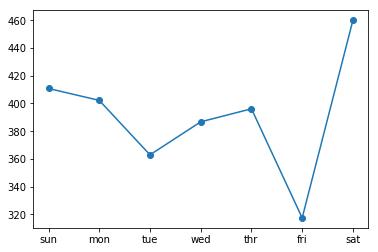

In [9]:
# Load the new file
dataset = pd.read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

# Split into train and test
train, test = split_dataset(dataset.values)

# Evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# Summarize scores
summarize_scores('lstm', score, scores)
# Plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()